Import the necessary packages

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

initialize the initial learning rate, number of epochs to train for and batch size

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [4]:
DIRECTORY = r"D:\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    cnt = 0
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)
    	cnt = cnt + 1
    print(category,":",cnt)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


with_mask : 1915
without_mask : 1918


perform one-hot encoding on the labels

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

convert the data and level list into numpy array for processing

In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

Split the dataset into training and testing set

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
print("Training Dataset: ",trainX.shape)
print("Testing Dataset: ",testX.shape)

Training Dataset:  (3066, 224, 224, 3)
Testing Dataset:  (767, 224, 224, 3)


construct the training image generator for data augmentation

In [7]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

load the MobileNetV2 network, ensuring the head FC layer sets are left off

In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

construct the head of the model that will be placed on top of the the base model

In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

place the head FC model on top of the base model (this will become the actual model we will train)

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

In [11]:
for layer in baseModel.layers:
	layer.trainable = False

compile our model

In [12]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


train the head of the network

In [13]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 166s 2s/step - loss: 0.4429 - accuracy: 0.8134 - val_loss: 0.1664 - val_accuracy: 0.9804
Epoch 2/20
95/95 [==============================] - 144s 1s/step - loss: 0.1606 - accuracy: 0.9552 - val_loss: 0.0819 - val_accuracy: 0.9896
Epoch 3/20
95/95 [==============================] - 143s 1s/step - loss: 0.1010 - accuracy: 0.9680 - val_loss: 0.0589 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 141s 1s/step - loss: 0.0773 - accuracy: 0.9776 - val_loss: 0.0460 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 136s 1s/step - loss: 0.0655 - accuracy: 0.9829 - val_loss: 0.0402 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 138s 1s/step - loss: 0.0636 - accuracy: 0.9809 - val_loss: 0.0399 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 136s 1s/step - loss: 0.0508 - accuracy: 0.9838 - val_loss: 0.0394 - val_accura

make predictions on the testing set

In [14]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


for each image in the testing set we need to find the index of the label with corresponding largest predicted probability

In [15]:
predIdxs = np.argmax(predIdxs, axis=1)

show a nicely formatted classification report

In [16]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



serialize the model to disk

In [17]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


plot the training loss and accuracy

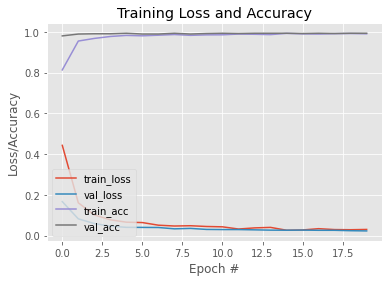

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")